In [54]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
df = pd.read_excel('Dev_data_to_be_shared.xlsx')

In [3]:
df.head()

,Primary key,Target,account_opening_date,country_code,demog_1,demog_2,income,demog_3,city_tier,occupation,...,demog_39,email_domain,demog_40,demog_41,others_42,others_43,others_44,others_45,demog_42,demog_43
0,1,0,2023-02-18,IN,53.0,3,100001 to 5L,101.0,Rural,Self_Employed,...,1,gmail,low,1,NaN,0.0,NaN,NaN,1,medium
1,2,0,2023-02-01,IN,55.0,1,0 to 1L,101.0,Tier 1,Salaried,...,1,gmail,High,1,NaN,NaN,NaN,NaN,1,High
2,3,0,2022-12-09,IN,55.0,3,0 to 1L,101.0,Tier 2,Self_Employed,...,1,gmail,medium,1,NaN,NaN,NaN,NaN,1,High
3,4,0,2023-03-31,IN,53.0,3,100001 to 5L,101.0,Tier 7,Self_Employed,...,1,gmail,High,1,NaN,NaN,NaN,NaN,1,High
4,5,0,2023-01-17,IN,55.0,6,0 to 1L,101.0,Tier 1,Student,...,1,gmail,low,1,NaN,NaN,NaN,NaN,1,medium


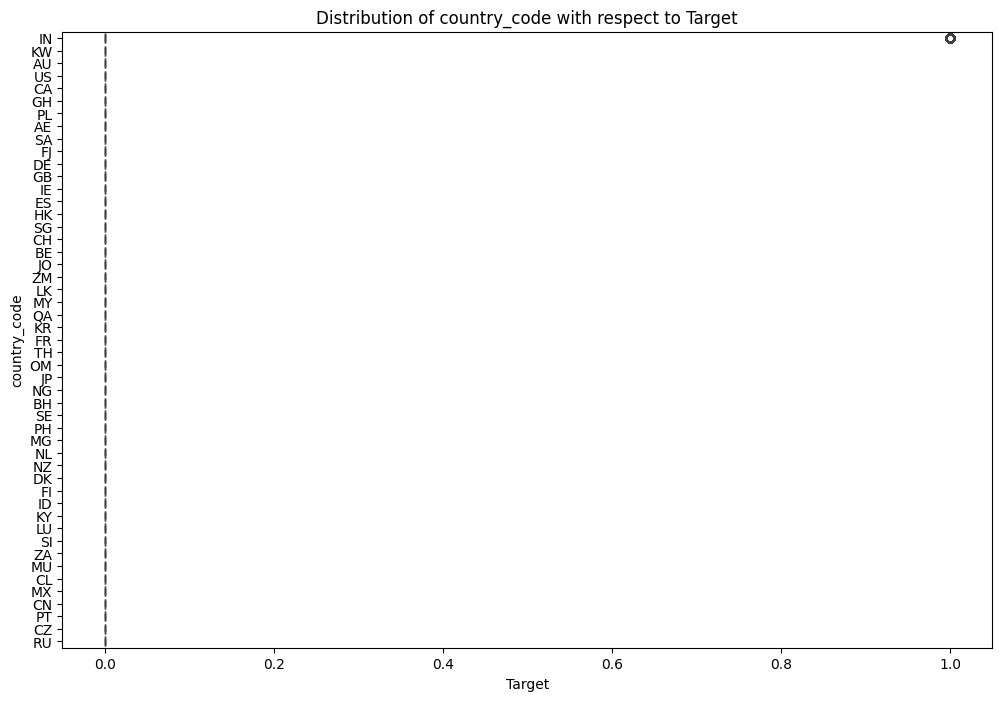

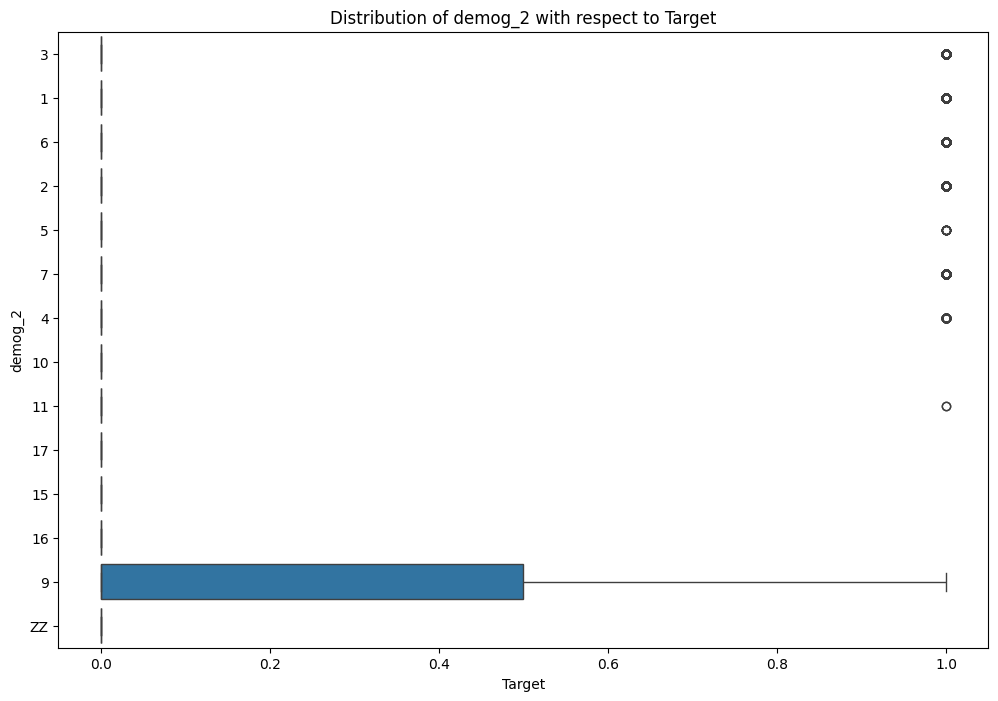

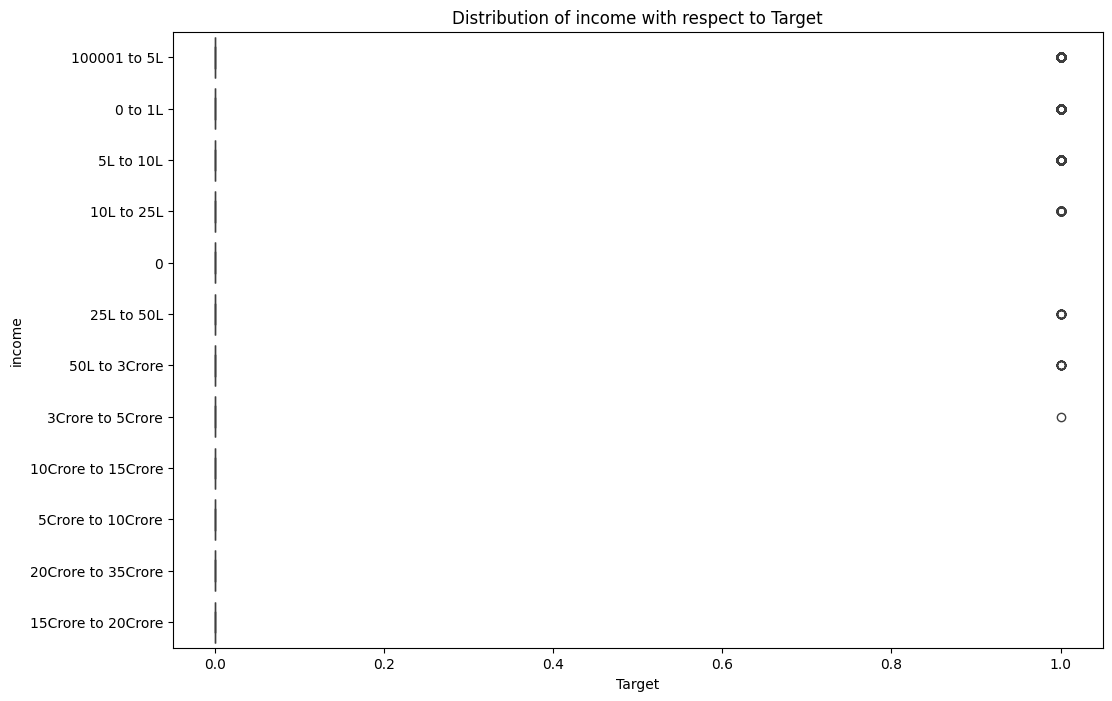

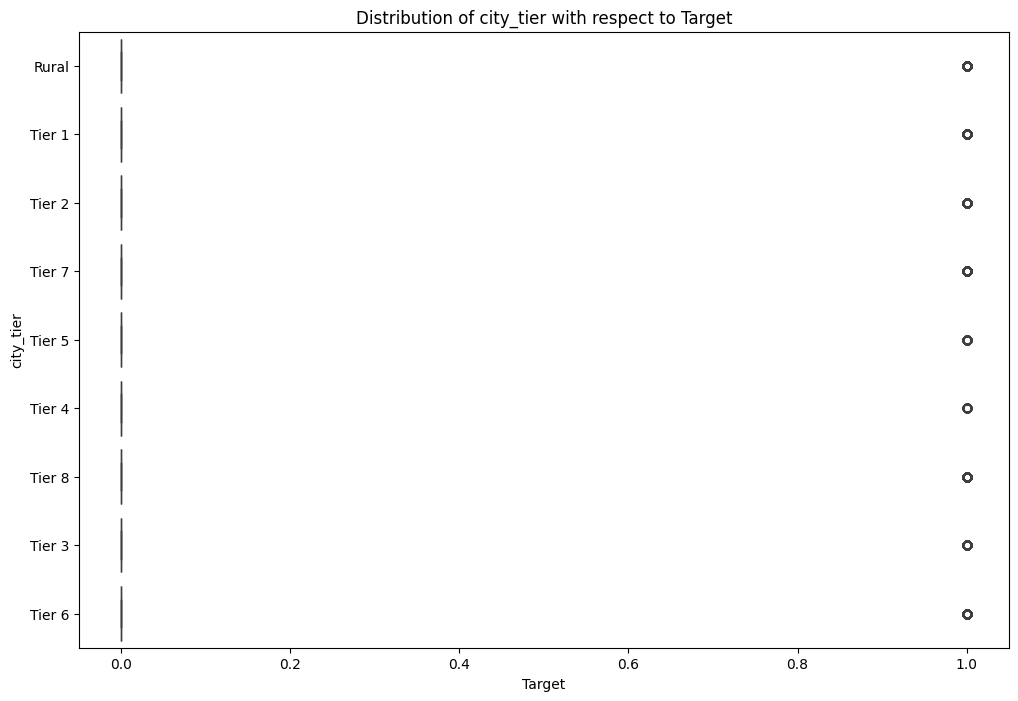

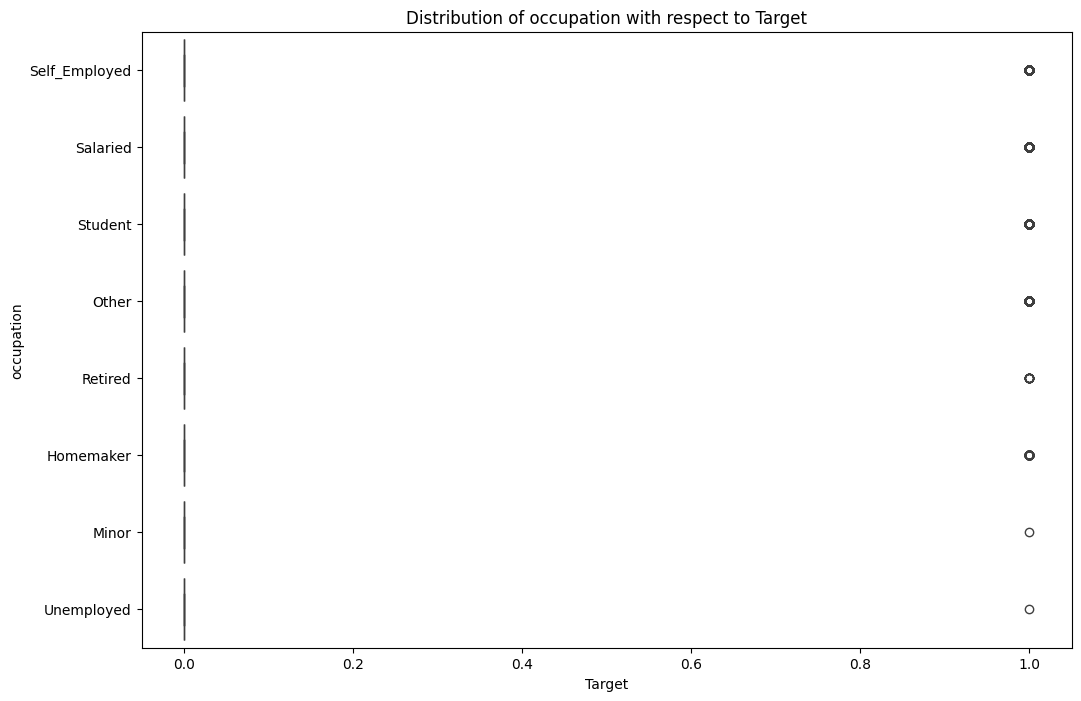

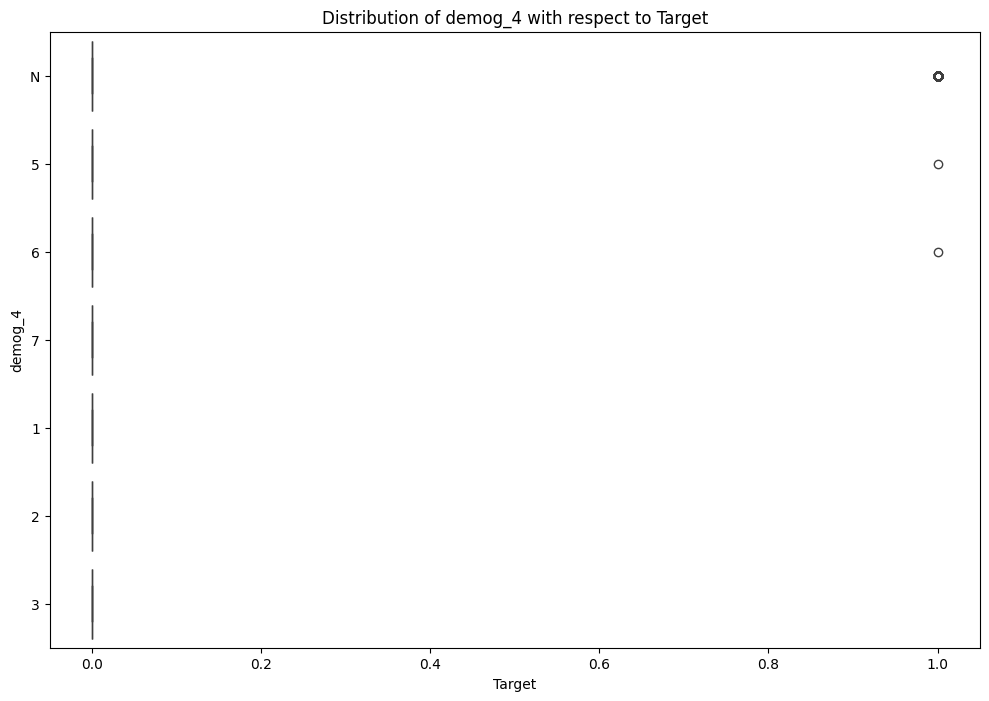

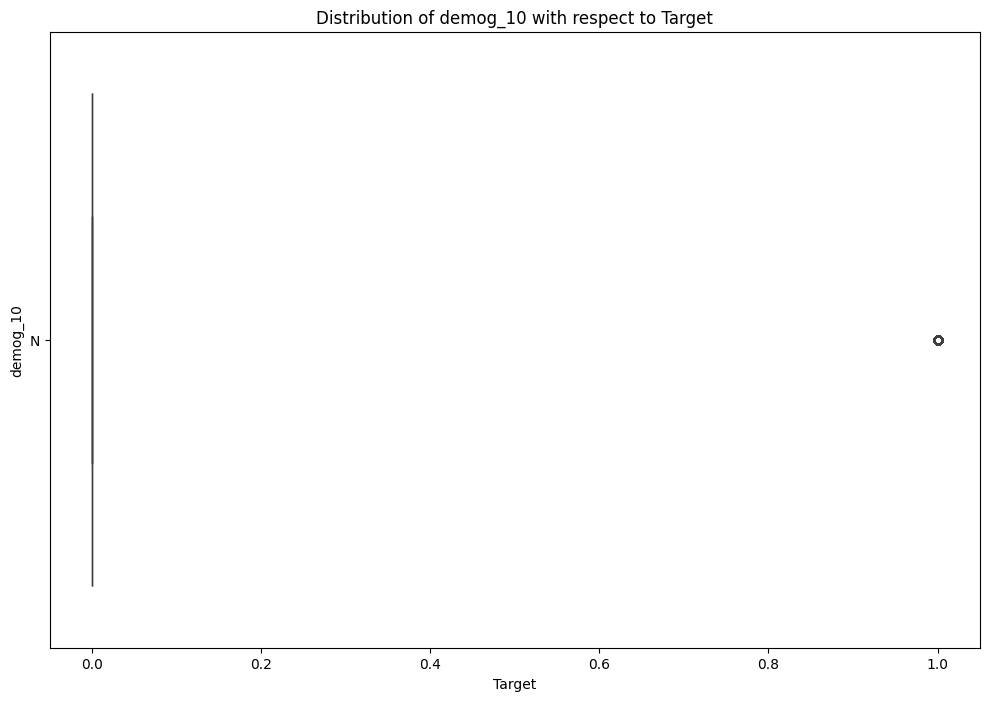

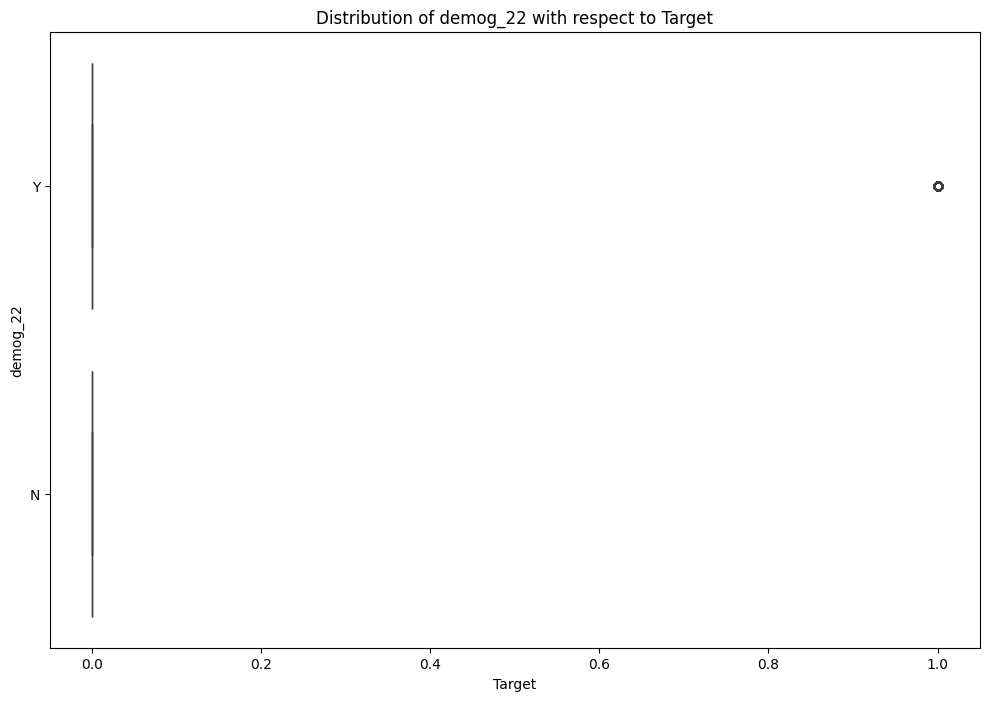

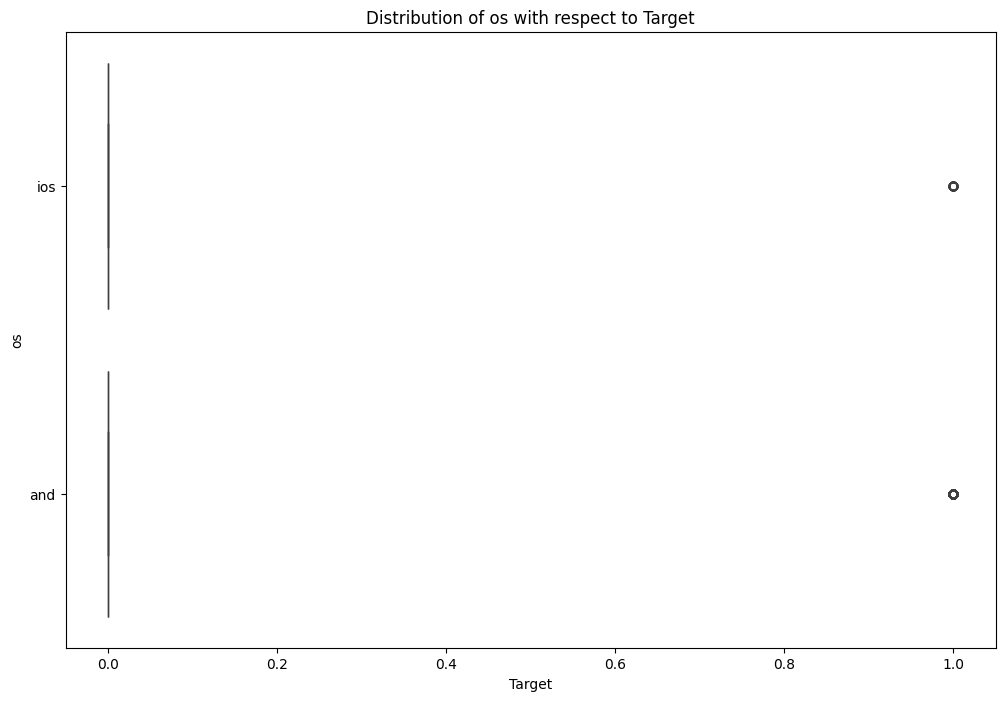

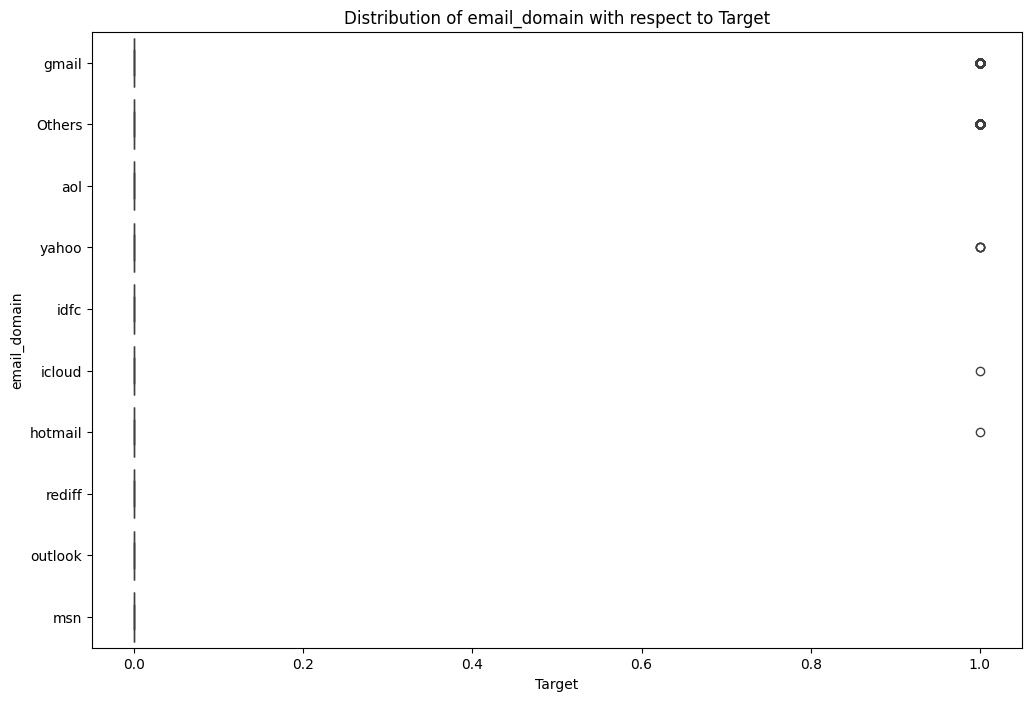

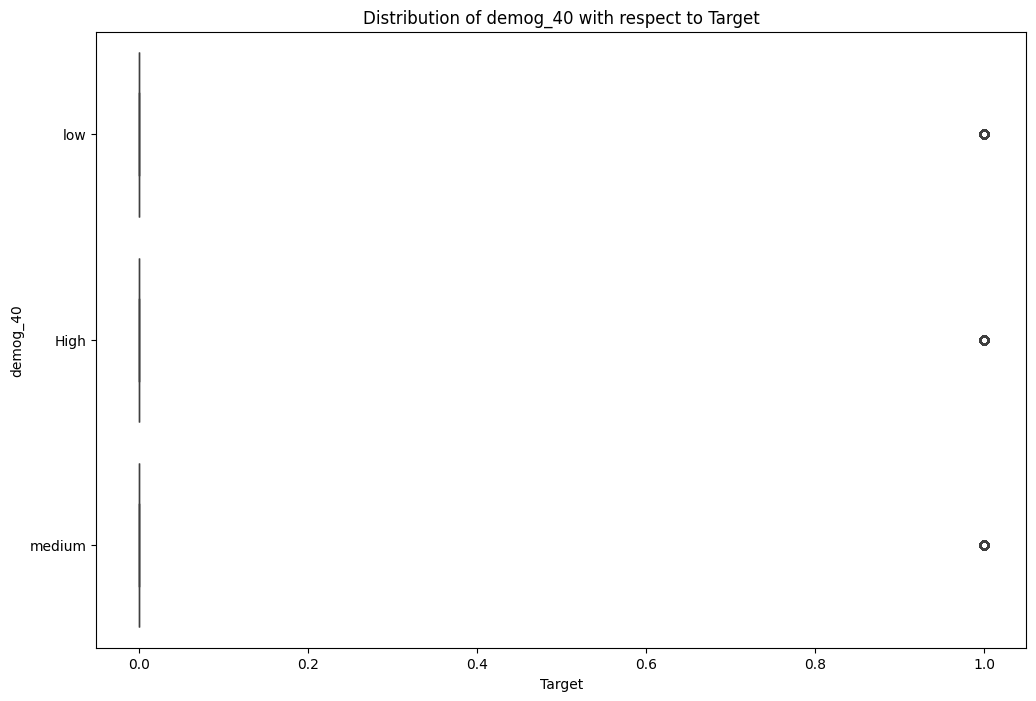

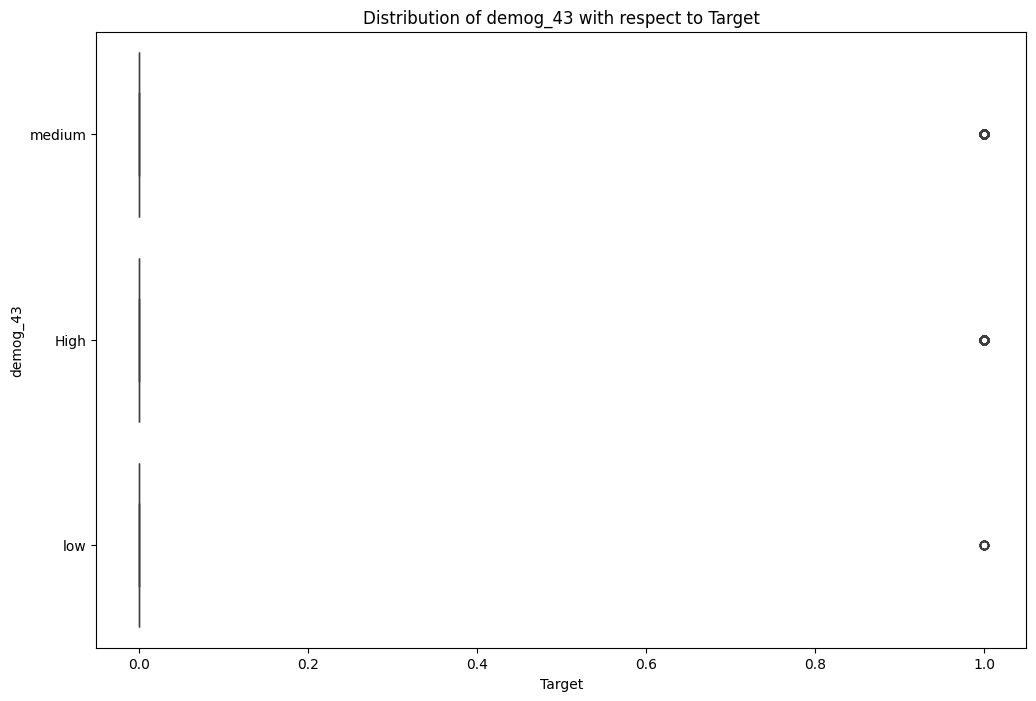

In [54]:
for col in df_new.columns:
    if df_new[col].dtype == 'object':
        plot_target_distribution_with_column(df_new, col, 'Target')

In [35]:
def drop_columns_with_high_blank_percentage(df, threshold=0.9):
    """
    Drop columns from a DataFrame with more than a specified percentage of blank values.

    Parameters:
    - df: pandas DataFrame
    - threshold: float, optional, default: 0.9
        The threshold percentage for blank values. Columns with blank values exceeding this threshold will be dropped.

    Returns:
    - df_filtered: pandas DataFrame
        DataFrame with columns having less than or equal to the specified threshold of blank values.
    """
    # Calculate the percentage of blank values in each column
    blank_percentage = df.isnull().mean()

    # Identify columns with blank values exceeding the threshold
    columns_to_drop = blank_percentage[blank_percentage > threshold].index

    # Drop the identified columns
    df_filtered = df.drop(columns=columns_to_drop)

    return df_filtered

# Example usage:
# Assuming 'your_dataframe' is your DataFrame
df_new = drop_columns_with_high_blank_percentage(df, threshold=0.75)

In [143]:
df_new

,Primary key,Target,account_opening_date,country_code,demog_1,demog_2,income,demog_3,city_tier,occupation,...,others_40,others_41,txn_80,txn_81,demog_39,email_domain,demog_40,demog_41,demog_42,demog_43
0,1,0,2023-02-18,IN,53.0,3,100001 to 5L,101.0,Rural,Self_Employed,...,0.0,0.0,1.0,1.0,1,gmail,low,1,1,medium
1,2,0,2023-02-01,IN,55.0,1,0 to 1L,101.0,Tier 1,Salaried,...,0.0,0.0,12.0,28.0,1,gmail,High,1,1,High
2,3,0,2022-12-09,IN,55.0,3,0 to 1L,101.0,Tier 2,Self_Employed,...,0.0,0.0,5.0,48.0,1,gmail,medium,1,1,High
3,4,0,2023-03-31,IN,53.0,3,100001 to 5L,101.0,Tier 7,Self_Employed,...,0.0,0.0,1.0,10.0,1,gmail,High,1,1,High
4,5,0,2023-01-17,IN,55.0,6,0 to 1L,101.0,Tier 1,Student,...,0.0,0.0,NaN,NaN,1,gmail,low,1,1,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,1,2022-12-21,IN,55.0,2,0 to 1L,101.0,Rural,Self_Employed,...,0.0,0.0,15.0,4.0,1,gmail,High,1,1,High
99996,99997,1,2023-03-17,IN,55.0,6,100001 to 5L,101.0,Rural,Student,...,0.0,0.0,2586.0,NaN,1,gmail,low,1,1,medium
99997,99998,1,2022-12-08,IN,55.0,1,100001 to 5L,101.0,Tier 6,Salaried,...,0.0,0.0,17.0,13.0,1,gmail,High,1,1,medium
99998,99999,1,2023-03-03,IN,55.0,1,5L to 10L,101.0,Tier 1,Other,...,0.0,0.0,13.0,62.0,1,gmail,High,1,1,High


In [36]:
def label_encode_and_impute_with_knn(df, column_name, k_neighbors=5):
    """
    Apply LabelEncoder to encode categorical values in a column and then replace missing values using k-nearest neighbors (KNN).

    Parameters:
    - df: pandas DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column with categorical values and missing values to be imputed.
    - k_neighbors: int, optional, default: 5
        The number of neighbors to use for imputation.

    Returns:
    - df_imputed: pandas DataFrame
        DataFrame with categorical values encoded and missing values in the specified column imputed using KNN.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_encoded_imputed = df.copy()

    # Apply LabelEncoder to the specified column
    le = LabelEncoder()
    df_encoded_imputed[column_name] = le.fit_transform(df_encoded_imputed[column_name])

    # Extract the column with encoded categorical values and missing values
    column_to_impute = df_encoded_imputed[[column_name]]

    # Initialize KNNImputer
    knn_imputer = KNNImputer(n_neighbors=k_neighbors)

    # Impute missing values using KNN
    column_imputed = knn_imputer.fit_transform(column_to_impute)

    # Update the DataFrame with the imputed values
    df_encoded_imputed[column_name] = column_imputed

    return df_encoded_imputed


In [37]:
# Example usage:
# Assuming 'your_dataframe' is your DataFrame and 'your_column' is the name of the column with missing values
for col in df_new.columns:
    if df_new[col].dtype == 'object':
        if col == 'demog_2':
            df_new.loc[df_new['demog_2'] == 'ZZ', 'demog_2'] = np.NaN
        if col =='income':
            df_new.loc[df_new['income'] == 0.0, 'income'] = '0 to 1L'
        if col == 'demog_4':
            df_new.loc[df_new['demog_4'] == 'N', 'demog_4'] = 4
        df_new = label_encode_and_impute_with_knn(df_new, col, k_neighbors=5)

In [31]:
# def label_encode_object_columns(df):
#     """
#     Encode object columns in a DataFrame using LabelEncoder.

#     Parameters:
#     - df: pandas DataFrame
#         The DataFrame containing object columns to be encoded.

#     Returns:
#     - df_encoded: pandas DataFrame
#         DataFrame with object columns encoded using LabelEncoder.
#     """
#     df_encoded = df.copy()

#     # Iterate through columns and encode if they are of type 'object'
#     for column in df_encoded.columns:
#         if df_encoded[column].dtype == 'object':
#             le = LabelEncoder()
#             df_encoded[column] = le.fit_transform(df_encoded[column])

#     return df_encoded

# # Example usage:
# # Assuming 'your_dataframe' is your DataFrame
# df_encoded = label_encode_object_columns(df_imputed)


In [23]:
for i,j in df_new.isna().sum().items():
    print(i,j)

Primary key 0
Target 0
account_opening_date 0
country_code 0
demog_1 3669
demog_2 0
income 0
demog_3 6
city_tier 0
occupation 0
demog_4 0
demog_5 25
demog_6 1
demog_7 6
demog_8 3751
demog_9 12914
demog_10 0
demog_11 1
demog_12 1
demog_13 3016
demog_14 3016
demog_15 3016
demog_16 3016
demog_17 1
demog_18 1
demog_19 1
demog_20 1
demog_21 1
demog_22 0
os 0
txn_1 25794
txn_2 25794
txn_3 25794
txn_4 25794
txn_5 25794
txn_6 25794
txn_7 25794
txn_8 25794
txn_9 25794
txn_10 25794
txn_11 25794
txn_12 25794
txn_13 25794
txn_14 25794
txn_15 25794
txn_16 25794
txn_17 25794
txn_18 25794
txn_19 25794
txn_20 25794
txn_21 25794
txn_22 25794
txn_23 25794
txn_24 25794
txn_25 25794
txn_26 25794
txn_27 25794
txn_28 25794
txn_29 25794
txn_30 25794
txn_31 25794
txn_32 25794
txn_33 25794
txn_34 25794
txn_35 25794
txn_36 25794
txn_37 25794
txn_38 25794
txn_39 25794
txn_40 25794
txn_41 25794
txn_42 25794
txn_43 25794
txn_44 25794
txn_45 25794
txn_46 25794
txn_47 25794
txn_48 25794
txn_49 25794
txn_50 25794
txn

In [12]:
for i,j in df_encoded.isna().sum().items():
    print(i,j)

Primary key 0
Target 0
account_opening_date 0
country_code 0
demog_1 3669
demog_2 0
income 0
demog_3 6
city_tier 0
occupation 0
demog_4 0
demog_5 25
demog_6 1
demog_7 6
demog_8 3751
demog_9 12914
demog_10 0
demog_11 1
demog_12 1
demog_13 3016
demog_14 3016
demog_15 3016
demog_16 3016
demog_17 1
demog_18 1
demog_19 1
demog_20 1
demog_21 1
demog_22 0
os 0
txn_1 25794
txn_2 25794
txn_3 25794
txn_4 25794
txn_5 25794
txn_6 25794
txn_7 25794
txn_8 25794
txn_9 25794
txn_10 25794
txn_11 25794
txn_12 25794
txn_13 25794
txn_14 25794
txn_15 25794
txn_16 25794
txn_17 25794
txn_18 25794
txn_19 25794
txn_20 25794
txn_21 25794
txn_22 25794
txn_23 25794
txn_24 25794
txn_25 25794
txn_26 25794
txn_27 25794
txn_28 25794
txn_29 25794
txn_30 25794
txn_31 25794
txn_32 25794
txn_33 25794
txn_34 25794
txn_35 25794
txn_36 25794
txn_37 25794
txn_38 25794
txn_39 25794
txn_40 25794
txn_41 25794
txn_42 25794
txn_43 25794
txn_44 25794
txn_45 25794
txn_46 25794
txn_47 25794
txn_48 25794
txn_49 25794
txn_50 25794
txn

In [150]:
df_new['demog_1'].value_counts()

55.0     66012
53.0     16230
401.0     6858
56.0      5260
51.0       864
52.0       859
54.0       157
405.0       48
421.0       18
57.0        14
252.0        5
123.0        2
124.0        1
84.0         1
227.0        1
58.0         1
Name: demog_1, dtype: int64

In [151]:
df_new['demog_1'].isna().sum()

3669

In [104]:
df_new.loc[df_new['demog_2'] == 'ZZ'] = np.NaN

In [106]:
df_new[df_new['demog_2'].isna()]

,Primary key,Target,account_opening_date,country_code,demog_1,demog_2,income,demog_3,city_tier,occupation,...,others_40,others_41,txn_80,txn_81,demog_39,email_domain,demog_40,demog_41,demog_42,demog_43
63,64.0,0.0,2023-03-09,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
66,67.0,0.0,2023-03-10,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
71,72.0,0.0,2023-03-02,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
75,76.0,0.0,2023-03-01,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
105,106.0,0.0,2022-12-15,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97866,97867.0,0.0,2023-02-28,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
97883,97884.0,0.0,2022-12-06,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
97888,97889.0,0.0,2022-12-06,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
97890,97891.0,0.0,2023-01-11,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN


In [121]:
df_new.loc[df_new['income'] == 0]

,Primary key,Target,account_opening_date,country_code,demog_1,demog_2,income,demog_3,city_tier,occupation,...,others_40,others_41,txn_80,txn_81,demog_39,email_domain,demog_40,demog_41,demog_42,demog_43
63,64.0,0.0,2023-03-09 00:00:00,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
66,67.0,0.0,2023-03-10 00:00:00,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
71,72.0,0.0,2023-03-02 00:00:00,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
75,76.0,0.0,2023-03-01 00:00:00,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
105,106.0,0.0,2022-12-15 00:00:00,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97883,97884.0,0.0,2022-12-06 00:00:00,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
97888,97889.0,0.0,2022-12-06 00:00:00,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
97890,97891.0,0.0,2023-01-11 00:00:00,NaN,NaN,NaN,0,101.0,NaN,Other,...,0.0,0.0,NaN,NaN,1.0,Others,NaN,0.0,0.0,NaN
97952,97953.0,0.0,2022-12-28 00:00:00,IN,56.0,1,0,101.0,Tier 1,Salaried,...,0.0,0.0,NaN,NaN,1.0,gmail,low,1.0,1.0,medium


<Figure size 1200x800 with 0 Axes>

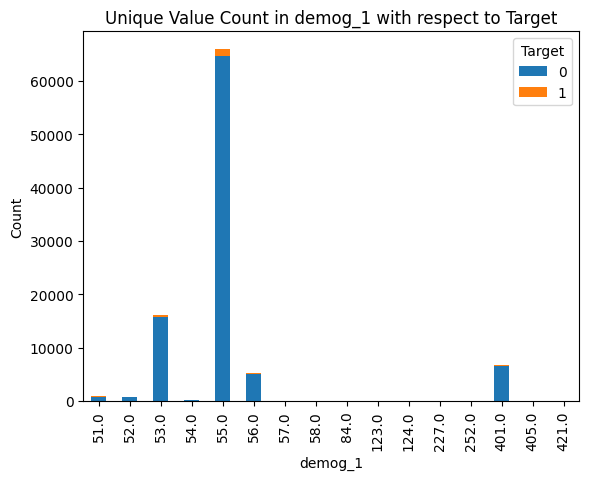

In [11]:
def plot_unique_value_count_with_target(df, categorical_column, target_column):
    """
    Create a bar plot to show the count of unique values in a categorical column with respect to a target variable.

    Parameters:
    - df: pandas DataFrame
        The DataFrame containing the data.
    - categorical_column: str
        The name of the categorical column.
    - target_column: str
        The name of the target variable.

    Returns:
    - None (displays the plot)
    """
    plt.figure(figsize=(12, 8))

    # Group by the categorical column and calculate the count of unique values for each target value
    grouped_data = df.groupby([categorical_column, target_column]).size().unstack()

    # Plot the bar plot
    grouped_data.plot(kind='bar', stacked=True)

    plt.title(f'Unique Value Count in {categorical_column} with respect to {target_column}')
    plt.xlabel(categorical_column)
    plt.ylabel('Count')

    plt.show()

# Example usage:
# Assuming 'your_dataframe' is your DataFrame, 'categorical_column' is the name of your categorical column,
# and 'target_variable' is the name of your target variable
plot_unique_value_count_with_target(df_new, 'demog_1', 'Target')

In [40]:
def impute_with_most_frequent(df, column_name):
    """
    Impute missing values in a column with the most frequent value (mode).

    Parameters:
    - df: pandas DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column with missing values to be imputed.

    Returns:
    - df_imputed: pandas DataFrame
        DataFrame with missing values in the specified column imputed with the most frequent value.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_imputed = df.copy()

    # Calculate the most frequent value (mode) of the column
    most_frequent_value = df_imputed[column_name].mode()[0]

    # Impute missing values with the most frequent value
    df_imputed[column_name].fillna(most_frequent_value, inplace=True)

    return df_imputed


In [41]:
for i,j in df_new.isna().sum().items():
    if j != 0:
        df_new = impute_with_most_frequent(df_new, i)

In [26]:
df_new

,Primary key,Target,account_opening_date,country_code,demog_1,demog_2,income,demog_3,city_tier,occupation,...,others_40,others_41,txn_80,txn_81,demog_39,email_domain,demog_40,demog_41,demog_42,demog_43
0,1,0,2023-02-18,20.0,53.0,2.0,1.0,101.0,0.0,5.0,...,0.0,0.0,1.0,1.0,1,2.0,1.0,1,1,2.0
1,2,0,2023-02-01,20.0,55.0,0.0,0.0,101.0,1.0,4.0,...,0.0,0.0,12.0,28.0,1,2.0,0.0,1,1,0.0
2,3,0,2022-12-09,20.0,55.0,2.0,0.0,101.0,2.0,5.0,...,0.0,0.0,5.0,48.0,1,2.0,2.0,1,1,0.0
3,4,0,2023-03-31,20.0,53.0,2.0,1.0,101.0,7.0,5.0,...,0.0,0.0,1.0,10.0,1,2.0,0.0,1,1,0.0
4,5,0,2023-01-17,20.0,55.0,5.0,0.0,101.0,1.0,6.0,...,0.0,0.0,1.0,9.0,1,2.0,1.0,1,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,1,2022-12-21,20.0,55.0,1.0,0.0,101.0,0.0,5.0,...,0.0,0.0,15.0,4.0,1,2.0,0.0,1,1,0.0
99996,99997,1,2023-03-17,20.0,55.0,5.0,1.0,101.0,0.0,6.0,...,0.0,0.0,2586.0,9.0,1,2.0,1.0,1,1,2.0
99997,99998,1,2022-12-08,20.0,55.0,0.0,1.0,101.0,6.0,4.0,...,0.0,0.0,17.0,13.0,1,2.0,0.0,1,1,2.0
99998,99999,1,2023-03-03,20.0,55.0,0.0,10.0,101.0,1.0,2.0,...,0.0,0.0,13.0,62.0,1,2.0,0.0,1,1,0.0


In [42]:
for i,j in df_new.isna().sum().items():
    print(i,j)

Primary key 0
Target 0
account_opening_date 0
country_code 0
demog_1 0
demog_2 0
income 0
demog_3 0
city_tier 0
occupation 0
demog_4 0
demog_5 0
demog_6 0
demog_7 0
demog_8 0
demog_9 0
demog_10 0
demog_11 0
demog_12 0
demog_13 0
demog_14 0
demog_15 0
demog_16 0
demog_17 0
demog_18 0
demog_19 0
demog_20 0
demog_21 0
demog_22 0
os 0
others_1 0
others_2 0
others_3 0
others_4 0
others_5 0
others_6 0
others_7 0
others_8 0
others_9 0
others_10 0
others_11 0
others_12 0
others_13 0
others_14 0
others_15 0
others_16 0
others_17 0
others_18 0
others_19 0
others_20 0
others_21 0
others_22 0
others_23 0
others_24 0
others_25 0
others_26 0
others_27 0
others_28 0
others_29 0
others_30 0
others_31 0
others_32 0
demog_23 0
demog_24 0
demog_25 0
demog_26 0
demog_27 0
demog_28 0
demog_29 0
demog_30 0
demog_31 0
demog_32 0
demog_33 0
demog_34 0
demog_35 0
demog_36 0
demog_37 0
demog_38 0
others_33 0
others_34 0
others_35 0
others_36 0
others_37 0
others_38 0
others_39 0
others_40 0
others_41 0
demog_39

In [38]:
def max_mean_values_for_pattern_columns(df, column_pattern):
    """
    Calculate the maximum and mean values for each row in columns with a specified pattern.

    Parameters:
    - df: pandas DataFrame
        The DataFrame containing the data.
    - column_pattern: str
        The pattern to search for in column names.

    Returns:
    - max_mean_values: pandas DataFrame
        DataFrame with two additional columns for maximum and mean values for each row in matching columns.
    """
    # Filter columns based on the specified pattern
    pattern_columns = [col for col in df.columns if column_pattern in col]

    # If no matching columns are found, return the original DataFrame
    if not pattern_columns:
        return df

    # Replace missing values with 0 in matching columns
    df[pattern_columns] = df[pattern_columns].fillna(0)
    
    # Calculate max and mean values for each row in matching columns
    max_no_of_txn = df[pattern_columns].max(axis=1)
    avg_no_of_txn = df[pattern_columns].mean(axis=1)
    min_no_of_txn = df[pattern_columns].min(axis=1)

    # Create a new DataFrame with additional columns for max and mean values
    max_mean_values = df.copy()
    max_mean_values['max_no_of_txn'] = max_no_of_txn
    max_mean_values['avg_no_of_txn'] = avg_no_of_txn
    max_mean_values['min_no_of_txn'] = min_no_of_txn

    # Drop columns with the specified pattern
    max_mean_values.drop(columns=pattern_columns, inplace=True)

    return max_mean_values

# Example usage:
# Assuming 'your_dataframe' is your DataFrame and 'your_pattern' is the pattern in column names
df_new = max_mean_values_for_pattern_columns(df_new, 'txn_')


In [43]:
# Create correlation matrix
corr_matrix = df_new.iloc[:,:-1].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df_new.drop(to_drop, axis=1, inplace=True)

In [45]:
df_new

,Primary key,Target,account_opening_date,country_code,demog_1,demog_2,income,demog_3,city_tier,occupation,...,others_40,others_41,demog_39,email_domain,demog_40,demog_42,demog_43,max_no_of_txn,avg_no_of_txn,min_no_of_txn
0,1,0,2023-02-18,20.0,53.0,2.0,1.0,101.0,0.0,5.0,...,0.0,0.0,1,2.0,1.0,1,2.0,29.0,1.061728,0.0
1,2,0,2023-02-01,20.0,55.0,0.0,0.0,101.0,1.0,4.0,...,0.0,0.0,1,2.0,0.0,1,0.0,150.0,5.753086,0.0
2,3,0,2022-12-09,20.0,55.0,2.0,0.0,101.0,2.0,5.0,...,0.0,0.0,1,2.0,2.0,1,0.0,244.0,9.765432,0.0
3,4,0,2023-03-31,20.0,53.0,2.0,1.0,101.0,7.0,5.0,...,0.0,0.0,1,2.0,0.0,1,0.0,17.0,0.938272,0.0
4,5,0,2023-01-17,20.0,55.0,5.0,0.0,101.0,1.0,6.0,...,0.0,0.0,1,2.0,1.0,1,2.0,6.0,0.271605,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,1,2022-12-21,20.0,55.0,1.0,0.0,101.0,0.0,5.0,...,0.0,0.0,1,2.0,0.0,1,0.0,18.0,1.567901,0.0
99996,99997,1,2023-03-17,20.0,55.0,5.0,1.0,101.0,0.0,6.0,...,0.0,0.0,1,2.0,1.0,1,2.0,2586.0,90.148148,0.0
99997,99998,1,2022-12-08,20.0,55.0,0.0,1.0,101.0,6.0,4.0,...,0.0,0.0,1,2.0,0.0,1,2.0,19.0,2.098765,0.0
99998,99999,1,2023-03-03,20.0,55.0,0.0,10.0,101.0,1.0,2.0,...,0.0,0.0,1,2.0,0.0,1,0.0,134.0,6.320988,0.0


In [55]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 72, stratify=y)

# print("Shape of x_train :", x_train.shape)
# print("Shape of x_test :", x_test.shape)
# print("Shape of y_train :", y_train.shape)
# print("Shape of y_test :", y_test.shape)

In [61]:
def format_date(col):
    temp = []
    for x in pd.to_datetime(col, format="%Y-%m-%d"):
        if x > pd.to_datetime('today'):    temp.append(x - pd.DateOffset(years=100))
        else:                              temp.append(x)
    return temp

In [62]:
df_new['account_opening_date']  =  format_date(df_new['account_opening_date'])
df_new['account_opening_day']    =  df_new['account_opening_date'].dt.day
df_new['account_opening_month']  =  df_new['account_opening_date'].dt.month
df_new['account_opening_year']   =  df_new['account_opening_date'].dt.year

In [67]:
df_new = df_new.drop('account_opening_date', axis=1)

In [68]:
y = df_new['Target']
x = df_new.drop('Target', axis=1)

In [ ]:
class RandomForestClassifierWithGridSearch:
    def __init__(self, X, y):
        self.X_train, self.X_test, self.X_val, self.y_train, self.y_test, self.y_val = self.split_data(X, y)
        self.rf_classifier = RandomForestClassifier(random_state=42)
        self.param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        self.stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        self.best_params, self.best_rf_model = self.tune_hyperparameters()
        self.y_pred_test, self.y_pred_val = self.evaluate_model()

    def split_data(self, X, y):
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
        return X_train, X_test, X_val, y_train, y_test, y_val

    def tune_hyperparameters(self):
        grid_search = GridSearchCV(estimator=self.rf_classifier, param_grid=self.param_grid, scoring='f1', cv=self.stratified_kfold, n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_params_, grid_search.best_estimator_

    def evaluate_model(self):
        y_pred_test = self.best_rf_model.predict(self.X_test)
        y_pred_val = self.best_rf_model.predict(self.X_val)
        return y_pred_test, y_pred_val

    def get_f1_score(self):
        f1_test = f1_score(self.y_test, self.y_pred_test, average='weighted')
        f1_val = f1_score(self.y_val, self.y_pred_val, average='weighted')
        return f1_test, f1_val


# Example usage:
# Assuming 'X' is your feature matrix and 'y' is your target variable
# Replace these with your actual feature matrix and target variable
random_forest_model = RandomForestClassifierWithGridSearch(X=x, y=y)
f1_test_score, f1_val_score = random_forest_model.get_f1_score()
print(f'F1 Score on the test set: {f1_test_score}')
print(f'F1 Score on the validation set: {f1_val_score}')
